# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
X.X     | XX/XX/2022 | A.B        | modif
1.1     | 30/09/2022 | I.S        | Remove preprocessing part by using `04.1_Anomaly - Feature definition.ipynb`
1.0     | 24/09/2022 | I.S        | Document creation

This notebook is the 1st try to refactor the code for BERT into a class object.
It was copied from 7_3_9_3_UNfrozen_2022_09_14.ipynb
We removed the preprocessing part, thanks to its centralisation in the main notebook `04.1_Anomaly - Feature definition.ipynb`

# IMPORT PACKAGES


/!\ Contains important Deep Learning package imports. 
Verify before substituting with others


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer

###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

# EVALUATION tools from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

###############################
# Deep Learning
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer, Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import callbacks


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# IMPORTANT: LOAD FUNCTIONS

Functions common to several sections of this code (we should actually put them in a separate file and load them from there)

In [2]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

In [3]:
def y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5):
  """
  Converts probabilities into 0's and 1's. We are still in the MULTILABEL context.
  Input: MULTILABEL predictions (probabilities whose sum for each sample may exceed > 1) coming directly from the model
  Using a user-defined threshold, return a MULTILABEL prediction vector 'y_pred' containing 0's and 1's
  """
  y_pred=[]
  for sample in y_pred_proba:
    y_pred.append([1 if i>= threshold else 0 for i in sample])
  y_pred = np.array(y_pred)

  return y_pred

In [4]:
def save_ML_outputs(dir_name, experiment_name, **kwargs):
    """
    Save multilabel classification outputs (y_pred_proba, y_pred, clf_rep) and target
    variable y_test.
    Uses **kwargs, so that the user may save only a part of the variables.

    Inputs
    -------
    - 'dir_name' (str): root directory, with slash at the end
    - 'experiment_name' (str): subdirectory, appended to 'dir_name'. Is also
      part of the .pkl file's name.
    - additional keyword arguments:
      - y_pred_proba
      - y_pred
      - y_test
      - 'clf_rep' (classification report in 
      dictionary format)
      - 'clf_rep_df' (classification report in 
      pd.DataFrame format)
    """
    # 'Unpack' the optional keyword arguments
    # kwargs behaves like a dictionary
    for key, val in zip(kwargs.keys(), kwargs.values()):
      print("Saving", str(key), "...")
      filename_pkl = str(key) + '_' + experiment_name + '.pkl'
      path_and_filename_pkl = dir_name + filename_pkl
      pkl.dump(val, open(path_and_filename_pkl, 'wb'))

    print("\n")
    print("Multilabel results were successfully saved in \n", dir_name)

In [5]:
def convert_clf_rep_to_df_multilabel_BERT(clf_rep, anomalies):
  '''
  Return the classification report in form of a pd.DataFrame.
  Tailored for extracting MULTILABEL BERT experiment results.
  The DataFrame contains dditional columns containing experiment information.
  Improvement: Their construction should be automatised as much as possible.
  
  Inputs
  -------
  - multilabel classification report in dictionary format
  (does not contain '0' and '1' keys)
  - anomalies (list of str): Used to label the classification report.
    Best use the .anomalies attribute of a 'DataPrepMultilabelBERT' class 
    object.

  Return
  -------
  - classification report in form of a pd.DataFrame with additional columns 
    containing experiment information
  '''
  # write classification report dictionnary into pd.DataFrame
  metrics = pd.DataFrame(clf_rep)

  # The rest of the code is basically kind of 'transposing' the format 
  # and adding extra columns with parameter values

  # Rename columns with anomaly names
  # Crete dictionary with correspondance among label indices and anomaly names
  anomaly_labels = dict(zip(metrics.columns[0:len(anomalies)], anomalies))
  metrics = metrics.rename(columns = anomaly_labels)

  ##########################################################
  # Create DataFrame in the right format for the plotting of results
  clf_rep_df = pd.DataFrame()
  for anomaly in metrics.columns[0:len(anomalies)]:

    temp_df = pd.DataFrame(index = metrics.index) # create temporary DataFrame with the 4 metrics as index
    temp_df['values'] = metrics.filter(items = [anomaly]).values # write the 4 values for the selected anomaly
    temp_df['anomaly'] = anomaly # fill in the column with the selected anomaly label
    clf_rep_df = pd.concat([clf_rep_df, temp_df])

  clf_rep_df = clf_rep_df.reset_index().rename(columns = {'index': 'metric'})

  # Fill in additionnal columns with metadata
  clf_rep_df['classifier'] = 'BERT_BASE'        # 'BERT_BASE' or 'DistilBERT' 
  clf_rep_df['preprocessing'] = 'raw'           # 'raw' or 'raw_stem' or 'PP'
  clf_rep_df['undersampling'] = 0               # 1 if undersampling was applied

  # layers run from 1 to 12
  clf_rep_df['UNfrozen_layers'] = '9_10_11_12'     # last 4 layers = '9_10_11_12', 'NO' if all layers frozen
  clf_rep_df['concat_layers']   = 'NO'       # '8_9_10_11' or 'NO' if no layers concatenation
  
  clf_rep_df['comments'] = 'last_hidden_state_CLS_random_state_222' # misc. comments, e.g. 'Flatten layer X' or 'max_length_345' or 'last_hidden_state_CLS'
  clf_rep_df['experiment_ID'] = '7_3_9_4'              # e.g. '7_5_2_1' if available
  #clf_rep_df['padding'] = padding              # 'pre' or 'post'
  #clf_rep_df['truncating'] = truncating        # 'pre' or 'post'
  #clf_rep_df['maxlen'] = maxlen   
  #clf_rep_df['num_words'] = num_words 

  # Reorder columns
  clf_rep_df = clf_rep_df[[\
                           'experiment_ID',
                           'classifier', 
                           'preprocessing', 
                           'undersampling',
                           'UNfrozen_layers',
                           'concat_layers',
                           'comments',
                           'anomaly', 
                           #'num_words', 
                           #'maxlen', 
                           #'padding', 
                           #'truncating', 
                           'metric', 
                           'values']]

  print("DataFrame length:", len(clf_rep_df)) #should be 56 = 14 anomalies * 4 metrics

  return clf_rep_df

# LOAD DATA

## Mount GDrive

In [6]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [7]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [8]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 2022_09_11_7_4_3_raw_narr_BERT_BASE_frozen_max_length_345.pkl
 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 df_for_Anomaly_prediction.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [9]:
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("df_for_Anomaly_prediction.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 96986 entries has been loaded


# Select only part of the data for testing the code

In [10]:
df = df.iloc[:20000]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1163382 to 898665
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Narrative                                     20000 non-null  object
 1   Anomaly                                       20000 non-null  object
 2   Narrative_PP_stemmed                          20000 non-null  object
 3   Narrative_Raw_Stemmed                         20000 non-null  object
 4   Narrative_Raw_Stemmed_str                     20000 non-null  object
 5   Narrative_PP_stemmed_str                      20000 non-null  object
 6   Anomaly_Deviation / Discrepancy - Procedural  20000 non-null  int64 
 7   Anomaly_Aircraft Equipment                    20000 non-null  int64 
 8   Anomaly_Conflict                              20000 non-null  int64 
 9   Anomaly_Inflight Event / Encounter            20000 non-null  int

## Define Anomaly_RootLabels_columns list from data set

In [12]:
# Retriece the list of Anomaly label columns
Anomaly_RootLabels_columns = []

for col in df.columns:
  if 'Anomaly_' in str(col):
      Anomaly_RootLabels_columns.append(col)

In [13]:
Anomaly_RootLabels_columns

['Anomaly_Deviation / Discrepancy - Procedural',
 'Anomaly_Aircraft Equipment',
 'Anomaly_Conflict',
 'Anomaly_Inflight Event / Encounter',
 'Anomaly_ATC Issue',
 'Anomaly_Deviation - Altitude',
 'Anomaly_Deviation - Track / Heading',
 'Anomaly_Ground Event / Encounter',
 'Anomaly_Flight Deck / Cabin / Aircraft Event',
 'Anomaly_Ground Incursion',
 'Anomaly_Airspace Violation',
 'Anomaly_Deviation - Speed',
 'Anomaly_Ground Excursion',
 'Anomaly_No Specific Anomaly Occurred']

# Multilabel with BERT


## Install 🤗 Hugging Face 

In [14]:
! pip install transformers 
! pip install datasets 
! pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 54.1 MB/s 
     |████████████████████████████████| 6.6 MB 41.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 63.9 MB/s 
     |████████████████████████████████| 115 kB 62.7 MB/s 
     |████████████████████████████████| 127 kB 64.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## CLASS DEFINITIONS

### DataPrepMultilabelBERT

In [15]:
class DataPrepMultilabelBERT():
  '''
  Prepare data for multilabel classification using BERT.
  An object of this class will return 3 'tf.data.Dataset' datasets, when called:
  tf_train_dataset, tf_validation_dataset, tf_test_dataset.

  Attributes created by the class's __call__() method
  ------------------------------------------------
  - text_and_labels: output of get_text_and_labels() method
  - df_train, df_validation, df_test: outputs of 
    train_validation_test_split() method
  - HF_dataset, train_dataset_HF, validation_dataset_HF, test_dataset_HF 
    outputs of convert_to_HF_dataset() method
  - tokenized_dataset, train_set_len: outputs of tokenize_the_BERT_way() method
  - tf_train_dataset, tf_validation_dataset, tf_test_dataset: outputs of
    convert_to_TensorFlow_datasets() method

  Methods
  ----------
  - __init__(), like every class
  - get_text_and_labels()
  - train_validation_test_split()
  - convert_to_HF_dataset()
  - tokenize_the_BERT_way()
  - convert_to_TensorFlow_dataset()
  - __call__() 
    Reminder: The __call__() method is called by executing 'object()', 
    where 'object' is an instance of the class.

  Attributes at class object instantiation
  ----------
  Attributes that are created within __call__(). They are the outputs of the 
  class's own methods.
  - BERT_model_name : string, "google/bert_uncased_L-12_H-768_A-12" for BERT BASE, 
    or one of the Small BERTs: "google/bert_uncased_L-12_H-128_A-2" 
    or #google/bert_uncased_L-2_H-128_A-2" (BERT tiny) 
    https://huggingface.co/google/bert_uncased_L-12_H-768_A-12
  - df: pd.DataFrame, containing 
      - ACN number (unique code for each ASRS database entry)
      - narratives
      - one-hot encoded labels for the narratives, e.g. Anomaly
  - anomalies: list of anomaly labels, e.g. as obtained from df.columns
  - text_input: string, which column to use as the text, 
    e.g. 'Narrative', 'Narrative_PP_stemmed_str', ...
  - max_length: int, default = 200, length of tokenized text 
  - batch_size: int, default = 32, batch size of the tf.data.Dataset created
  - random_state : for the train_validation_test_split() method of the class, 
    see corresponding Docstring
  - first_split_prop : for the train_validation_test_split() method of the class, 
    see corresponding Docstring
  - second_split_prop : for the train_validation_test_split() method of the class, 
    see corresponding Docstring
  '''
  def __init__(self, 
               BERT_model_name, 
               df, 
               anomalies, 
               text_input = 'Narrative', 
               max_length = 200,
               batch_size = 32,
               random_state = 12, 
               first_split_prop = 0.2, 
               second_split_prop = 0.2):

    self.BERT_model_name = BERT_model_name
    self.df = df
    self.anomalies = anomalies
    self.text_input = text_input
    self.max_length = max_length
    self.batch_size = batch_size
    self.random_state = random_state
    self.first_split_prop = first_split_prop 
    self.second_split_prop = second_split_prop

    # Instantiate a data_collator used by the method 'convert_to_TensorFlow_datasets()'
    from transformers import DefaultDataCollator
    self.data_collator = DefaultDataCollator(return_tensors="tf")

  def get_text_and_labels(self, df, anomalies, text_input):
    '''
    Return a DataFrame containing a list of binary multilabels and a text per row.
    Inputs
    ------
    - df: pd.DataFrame
    - anomalies: list of Anomaly label names
    - text_input: name of the column of df that contains the texts, e.g. 'Narrative'
    '''
    print("Creating multilabels...")
    text_and_labels = df[anomalies]
    text_and_labels['labels']  = text_and_labels.apply(lambda r: tuple(r), axis=1).apply(np.array)
    # /!\ has to be 'labels' and not 'label' or other. HuggingFace expects this. 
    # With 'label', I got AssertError in the conversion to tf.dataset
    text_and_labels = text_and_labels.drop(columns = self.anomalies)
    text_and_labels['text'] = df[self.text_input]
    text_and_labels = text_and_labels.reset_index().drop(columns = ['ACN'])
    print("Example of text and corresponding multilabel:\n")
    print(text_and_labels.iloc[0])
    print("\n")
    print("get_text_and_labels() done")
    print(30*"*", "\n")
    return text_and_labels


  def train_validation_test_split(self, 
                                  text_and_labels, 
                                  first_split_prop, 
                                  second_split_prop,
                                  random_state):
    '''
    Split arrays or matrices into random train, validation and test subsets.
    First separate test set from df, then separate validation set.

    Inputs
    ----------
    - text_and_labels : pd.DataFrame containing only the columns 'text' and 'label'
    - first_split_prop : float, default = 0.2 
      Proportion to use in the first split.
    - second_split_prop : float, default = 0.2
      Proportion to use in the second split.
    - random_state : default = 12

    Return
    ----------
    pd.DataFrames
    - df_train
    - df_validation
    - df_test
    '''
    print("Splitting dataset...")
    # Train-test split  
    df_train_plus_val, df_test, = train_test_split(text_and_labels, 
                                                    test_size= first_split_prop,
                                                    random_state = random_state) 
    # Train-validation split 
    df_train, df_validation, = train_test_split(df_train_plus_val, 
                                                    test_size= second_split_prop,
                                                    random_state = random_state) 

    print("train set length:", len(df_train))
    print("validation set length:", len(df_validation))
    print("test set length:", len(df_test))
    
    print("\n")
    print("train_validation_test_split() done")
    print(30*"*", "\n")
    return df_train, df_validation, df_test

  def convert_to_HF_dataset(self, df_train, df_validation, df_test):
    '''
    Convert pd.DataFrames to 🤗 datasets and combining them into a 🤗 DatasetDict.
    
    Input
    -------
    pd.DataFrames
    - df_train
    - df_validation
    - df_test

    Return
    -------
    - HF_dataset: 🤗 DatasetDict
    - Its three constituent 🤗 datasets: 
      - train_dataset_HF
      - validation_dataset_HF
      - test_dataset_HF
    '''
    print("Combining pd.DataFrames into a HuggingFace dataset...")
    # IMPORT 🤗 PACKAGES
    # when putting outside this function, it did not recognize 'Dataset'
    from datasets import Dataset, DatasetDict
    
    # Convert into 🤗 datasets  
    train_dataset_HF = Dataset.from_dict(df_train)
    validation_dataset_HF = Dataset.from_dict(df_validation)
    test_dataset_HF = Dataset.from_dict(df_test)
    # use from_dict() and not from_pandas()
    # otherwise you get an extra key, smth litke '__index col__'
    print("\n Structure of Hugging Face dataset (train):", train_dataset_HF)
    
    # 'merge' the three 🤗 datasets into a single 🤗 DatasetDict
    HF_dataset = DatasetDict({"train": train_dataset_HF, 
                              "validation": validation_dataset_HF, 
                              "test": test_dataset_HF})
    print("\n Structure of the complete Hugging Face dataset:\n", HF_dataset)
    print("\n First entry of the train dataset:\n", HF_dataset["train"][0])
    print("\n")
    print("convert_to_HF_dataset() done")
    print(30*"*", "\n")
    return HF_dataset, train_dataset_HF, validation_dataset_HF, test_dataset_HF


  def tokenize_the_BERT_way(self, HF_dataset, BERT_model_name, max_length):
    '''
    Tokenize a 🤗 dataset with the appropriate BERT tokenizer, downloaded from 🤗

    Inputs
    ------
    - HF_dataset: 🤗 DatasetDict
    - BERT_model_name (string), as defined on the 🤗 website
    - max_length (int), desired length of sequence 
    
    Return
    ------
    - tokenized_dataset, a 🤗 DatasetDict
    - train_set_len (int): length of the train set
    '''
    # instantiate tokenizer
    # IMPORT 🤗 PACKAGES
    from transformers import AutoTokenizer
    # TOKENIZE using a pre-trained tokenizer from HuggingFace
    
    tokenizer = AutoTokenizer.from_pretrained(BERT_model_name)
    max_length = max_length

    # Define a function in order to use .map() below
    def tokenize_function(examples):
      return tokenizer(examples["text"], 
                       padding='max_length', max_length = max_length, # same value as we used for WordEmbedding 
                       truncation = True
                       #return_tensors="tf"
                       )
    
    # Map the tokenization function onto our dataset
    # it is ok to apply it also to the test set, since it is a *pretrained* tokenizer,
    # i.e. it will not train on our data
    print("Performing tokenization in batches on: train, validation, test sets...")

    # Auxialiary variable, see below
    pre_tokenizer_columns = set(HF_dataset["train"].features)
    
    tokenized_dataset = HF_dataset.map(tokenize_function, batched = True)
    # The tokenizer uses its own batch_size, not the class attribute

    # Display the additional columns created by the tokenizer
    # They are necessary inputs for BERT
    tokenizer_columns = list(set(tokenized_dataset["train"].features) - pre_tokenizer_columns)
    print("Columns added by tokenizer:", tokenizer_columns)
    print("\n Structure of the complete tokenized Hugging Face dataset:\n", tokenized_dataset)
    print("\n")
    print("tokenize_the_BERT_way() done")
    print(30*"*", "\n")
    # return length of tokenized_dataset["train"] to feed it to AdamW optimizer
    train_set_len = len(tokenized_dataset["train"])

    return tokenized_dataset, train_set_len

  def convert_to_TensorFlow_datasets(self, tokenized_dataset_to_convert, key ="test"):
    """
    Convert our datasets to tf.data.Dataset, which Keras understands natively. 

    Inputs
    -------
    - tokenized_dataset_to_convert: a 🤗 DatasetDict
    - key (str): key of the 🤗 DatasetDict "train", "validation", "test"

    Return
    -------
    - tf_dataset: tf.data.Dataset
    """
    # Two ways to do the conversion: 
    # (i) use the slightly more low-level Dataset.to_tf_dataset() method
    # (ii) use Model.prepare_tf_dataset(). 
    # The Model method can inspect the model to determine which column names it 
    # can use as input, which means you don't need to specify them yourself. 
    # Unless our samples are all the same length, we will also need to pass 
    # a tokenizer or collate_fn so that the tf.data.Dataset knows 
    # how to pad and combine samples into a batch.
    tf_dataset = tokenized_dataset_to_convert[key].to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["labels"],
        shuffle=False,
        collate_fn = self.data_collator,
        batch_size=self.batch_size)
    
    return tf_dataset

  def __call__(self):
      """
      Function that makes class instances being callable.
      This function calls all methods of the class and
      (i)  passes the output of one function as input of the next one
      (ii) writes the method outputs as additional class attributes. This 
      is useful for fetching some of these outputs later.

      Inputs
      ------
      No inputs.

      Return
      ------
      - Outputs and in the same time, attributes of the class 
        - self.tf_train_dataset
        - self.tf_validation_dataset
        - self.tf_test_dataset

      """
      self.text_and_labels = self.get_text_and_labels(self.df, 
                                                      self.anomalies, 
                                                      self.text_input)
      
      self.df_train, self.df_validation, self.df_test = self.train_validation_test_split(self.text_and_labels, 
                                                                                         self.first_split_prop, 
                                                                                         self.second_split_prop,
                                                                                         self.random_state)
      
      self.HF_dataset, self.train_dataset_HF, self.validation_dataset_HF, self.test_dataset_HF = self.convert_to_HF_dataset(self.df_train, 
                                                                                                                            self.df_validation, 
                                                                                                                            self.df_test)
      self.tokenized_dataset, self.train_set_len = self.tokenize_the_BERT_way(self.HF_dataset, 
                                                                              self.BERT_model_name, 
                                                                              self.max_length)
      
      print("Converting tokenized_dataset into tf.data.Dataset datasets...")
      self.tf_train_dataset = self.convert_to_TensorFlow_datasets(tokenized_dataset_to_convert = self.tokenized_dataset, key = "train")
      self.tf_validation_dataset = self.convert_to_TensorFlow_datasets(tokenized_dataset_to_convert = self.tokenized_dataset, key = "validation")
      self.tf_test_dataset = self.convert_to_TensorFlow_datasets(tokenized_dataset_to_convert = self.tokenized_dataset, key = "test")
    
      print("\n Structure of the train tf.Data.dataset:\n", self.tf_train_dataset)
      print("\n")
      print("Content of one batch: the narratives have been converted into 'input_ids', 'token_type_ids', 'attention_mask' (see below)")
      print("The multilabels are shown last ('array'). \n")
      print(next(self.tf_train_dataset.as_numpy_iterator()))
      print("\n")
      print("convert_to_TensorFlow_datasets() done")
      print(30*"*", "\n")

      return self.tf_train_dataset, self.tf_validation_dataset, self.tf_test_dataset

In [16]:
preprocess = DataPrepMultilabelBERT(BERT_model_name = "google/bert_uncased_L-2_H-128_A-2",#"google/bert_uncased_L-12_H-768_A-12", 
                                    df = df, 
                                    anomalies = Anomaly_RootLabels_columns)
#my_df1, my_df12, my_df13 = preprocess.train_validation_test_split()
tf_train_dataset, tf_validation_dataset, tf_test_dataset = preprocess()

Creating multilabels...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Example of text and corresponding multilabel:

labels           [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text      I was the pilot flying performing the takeoff....
Name: 0, dtype: object


get_text_and_labels() done
****************************** 

Splitting dataset...
train set length: 12800
validation set length: 3200
test set length: 4000


train_validation_test_split() done
****************************** 

Combining pd.DataFrames into a HuggingFace dataset...

 Structure of Hugging Face dataset (train): Dataset({
    features: ['labels', 'text'],
    num_rows: 12800
})

 Structure of the complete Hugging Face dataset:
 DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 12800
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 3200
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 4000
    })
})

 First entry of the train dataset:
 {'labels': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0

Downloading:   0%|          | 0.00/382 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Performing tokenization in batches on: train, validation, test sets...


  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Columns added by tokenizer: ['attention_mask', 'token_type_ids', 'input_ids']

 Structure of the complete tokenized Hugging Face dataset:
 DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12800
    })
    validation: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
})


tokenize_the_BERT_way() done
****************************** 

Converting tokenized_dataset into tf.data.Dataset datasets...

 Structure of the train tf.Data.dataset:
 <PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)}, 

#### OLD

In [17]:
# #@title Default title text
# class DataPrepMultilabelBERT():
#   '''
#   Prepare data for multilabel classification using BERT.
#   An object of this class will return 3 'tf.data.Dataset' datasets, when called:
#   tf_train_dataset, tf_validation_dataset, tf_test_dataset.

#   Attributes
#   ----------
#   BERT_model_name : string, "google/bert_uncased_L-12_H-768_A-12" for BERT BASE, 
#   or "google/bert_uncased_L-12_H-128_A-2" for one of the Small BERTs. See Hugging Face documentation
  
#   df: pd.DataFrame, containing 
#     - ACN number (unique code for each ASRS database entry)
#     - narratives
#     - one-hot encoded labels for the narratives, e.g. Anomaly
  
#   anomalies: list of anomaly labels, e.g. as obtained from df.columns

#   text_input: string, which column to use as the text, e.g. 'Narrative', 'Narrative_PP_stemmed_str', ...

#   max_length: int, default = 200, length of tokenized text 

#   batch_size: int, default = 32, batch size of the tf.data.Dataset created

#   random_state : for the train_validation_test_split() method of the class, see corresponding Docstring

#   first_split_prop : for the train_validation_test_split() method of the class, see corresponding Docstring
  
#   second_split_prop : for the train_validation_test_split() method of the class, see corresponding Docstring

#   Methods
#   ----------
#   The next method calls the previous one.
#   The __call__() method calls the last method in the chain.
#   Call the __call__() method with 'object()', where object is an instance of the class.
  
#   Call intermediate functions with object.intermediate_function()
#   '''

#   def __init__(self, 
#                BERT_model_name, 
#                df, 
#                anomalies, 
#                text_input = 'Narrative', 
#                max_length = 200,
#                batch_size = 32,
#                random_state = 12, 
#                first_split_prop = 0.2, 
#                second_split_prop = 0.2):

#     self.BERT_model_name = BERT_model_name
#     self.df = df
#     self.anomalies = anomalies
#     self.text_input = text_input
#     self.max_length = max_length
#     self.batch_size = batch_size
#     self.random_state = random_state
#     self.first_split_prop = first_split_prop 
#     self.second_split_prop = second_split_prop

#     # Instantiate a data_collator used by the method 'convert_to_TF_datasets()'
#     from transformers import DefaultDataCollator
#     self.data_collator = DefaultDataCollator(return_tensors="tf")

#   def get_text_and_labels(self):
#     '''
#     Create a DataFrame containing a list of binary multilabels and a text per row.
#     This functions fetches direclty the class attributes as inputs.
#     '''
#     print("Creating multilabels...")
#     text_and_labels = df[self.anomalies]
#     text_and_labels['labels']  = text_and_labels.apply(lambda r: tuple(r), axis=1).apply(np.array)
#     # has to be 'labels' and not 'label'. HuggingFace expects this. 
#     # With 'label', I got AssertError in the conversion to tf.dataset
#     text_and_labels = text_and_labels.drop(columns = self.anomalies)
#     text_and_labels['text'] = df[self.text_input]
#     text_and_labels = text_and_labels.reset_index().drop(columns = ['ACN'])
    
#     print("Example of text and corresponding multilabel:\n")
#     print(text_and_labels.iloc[0])
#     print("\n")
#     print("get_text_and_labels() done")
#     print(30*"*", "\n")
#     return text_and_labels


#   def train_validation_test_split(self):
#     '''
#     Split arrays or matrices into random train, validation and test subsets.
#     First, separate test set from df.
#     Then, separate validation set.

#     Inputs
#     ----------
#     df : pd.DataFrame 
    
#     random_state : default = 12
    
#     first_split_prop : float, default = 0.2 
#       Proportion to use in the first split.

#     second_split_prop : float, default = 0.2
#       Proportion to use in the second split.

#     Returns
#     ----------
#     df_train
#     df_validation
#     df_test
#     '''
    
#     # Call the previous class function defined above
#     text_and_labels = self.get_text_and_labels()
#     print("Splitting dataset...")
#     # Train-test split  
#     df_train_plus_val, df_test, = train_test_split(text_and_labels, 
#                                                     test_size= self.first_split_prop,
#                                                     random_state = self.random_state) 
#     # Train-validation split 
#     df_train, df_validation, = train_test_split(df_train_plus_val, 
#                                                     test_size= self.second_split_prop,
#                                                     random_state = self.random_state) 

#     print("train set length:", len(df_train))
#     print("validation set length:", len(df_validation))
#     print("test set length:", len(df_test))
    
#     print("\n")
#     print("train_validation_test_split() done")
#     print(30*"*", "\n")
#     return df_train, df_validation, df_test


#   def convert_to_HF_dataset(self):
#     '''
#     Convert pd.DataFrame to 🤗 dataset.
#     Returns the 🤗 dataset and its three constituents: train_dataset_HF, validation_dataset_HF, test_dataset_HF
#     '''
#     # Call the previous class function defined above
#     df_train, df_validation, df_test = self.train_validation_test_split()

#     print("Combining pd.DataFrames into a HuggingFace dataset...")
#     # IMPORT 🤗 PACKAGES
#     # when putting outside this function, it did not recognize 'Dataset'
#     from datasets import Dataset, DatasetDict

#     train_dataset_HF = Dataset.from_dict(df_train)
#     validation_dataset_HF = Dataset.from_dict(df_validation)
#     test_dataset_HF = Dataset.from_dict(df_test)
#     # use from_dict() and not from_pandas()
#     # otherwise you get an extra key, smth litke '__index col__'

#     print("\n Structure of Hugging Face dataset (train):", train_dataset_HF)
    
#     # 'merge' the three 🤗 datasets into one
#     HF_dataset = DatasetDict({"train": train_dataset_HF, 
#                               "validation": validation_dataset_HF, 
#                               "test": test_dataset_HF})
#     print("\n Structure of the complete Hugging Face dataset:\n", HF_dataset)
#     print("\n First entry of the train dataset:\n", HF_dataset["train"][0])

#     print("\n")
#     print("convert_to_HF_dataset() done")
#     print(30*"*", "\n")
#     return HF_dataset, train_dataset_HF, validation_dataset_HF, test_dataset_HF


#   def tokenize_the_BERT_way(self):
    
#     # Call the previous class function defined above
#     HF_dataset = self.convert_to_HF_dataset()[0]

#     # instantiate tokenizer
#     # IMPORT 🤗 PACKAGES
#     from transformers import AutoTokenizer
#     # TOKENIZE using a pre-trained tokenizer from HuggingFace
    
#     tokenizer = AutoTokenizer.from_pretrained(self.BERT_model_name)
#     max_length = self.max_length

#     # Define a function in order to use .map() below
#     def tokenize_function(examples):
#       return tokenizer(examples["text"], 
#                        padding='max_length', max_length = max_length, # same value as we used for WordEmbedding 
#                        truncation = True
#                        #return_tensors="tf"
#                        )

#     # Auxialiary variable, see below
#     pre_tokenizer_columns = set(HF_dataset["train"].features)

#     # map the tokenization function onto our dataset
#     # it is ok to apply it also to the test set, since it is a *pretrained* tokenizer,
#     # i.e. it will not train on our data
#     print("Performing tokenization in batches on: train, validation, test sets...")
#     tokenized_dataset = HF_dataset.map(tokenize_function, batched = True)
#     # The tokenizer uses its own batch_size, not the class attribute

#     # Display the additional columns created by the tokenizer
#     # They are necessary inputs for BERT
#     tokenizer_columns = list(set(tokenized_dataset["train"].features) - pre_tokenizer_columns)
#     print("Columns added by tokenizer:", tokenizer_columns)
#     print("\n Structure of the complete tokenized Hugging Face dataset:\n", tokenized_dataset)

#     print("\n")
#     print("tokenize_the_BERT_way() done")
#     print(30*"*", "\n")
#     # return len(tokenized_dataset["train"] to feed into AdamW optimizer
#     return tokenized_dataset, len(tokenized_dataset["train"])


#   def convert_to_TF_datasets(self, tokenized_dataset_to_convert, key ="test"):
#     """
#     Convert our datasets to tf.data.Dataset, which Keras understands natively. 
#     Two ways to do this: 
#     (i) use the slightly more low-level Dataset.to_tf_dataset() method
#     (ii) use Model.prepare_tf_dataset(). 
#     The Model method can inspect the model to determine which column names it 
#     can use as input, which means you don't need to specify them yourself. 
#     Unless our samples are all the same length, we will also need to pass 
#     a tokenizer or collate_fn so that the tf.data.Dataset knows 
#     how to pad and combine samples into a batch.

#     Inputs
#     ---------
#     train / validation / test set from tokenized_dataset (HuggingFace data format), 
#     e.g. tokenized_dataset["test"]

#     """
#     tf_dataset = tokenized_dataset_to_convert[key].to_tf_dataset(
#         columns=["attention_mask", "input_ids", "token_type_ids"],
#         label_cols=["labels"],
#         shuffle=False,
#         collate_fn = self.data_collator,
#         batch_size=self.batch_size)
    
#     return tf_dataset

#   def __call__(self):
#       # call the last functions in the chain of functions above 
#       # better coding practice: call all functions here one after the other?
#       tokenized_dataset, train_set_len = self.tokenize_the_BERT_way()
#       print("Converting tokenized_dataset into tf.data.Dataset datasets...")
#       tf_train_dataset = self.convert_to_TF_datasets(tokenized_dataset_to_convert=tokenized_dataset, key = "train")
#       tf_validation_dataset = self.convert_to_TF_datasets(tokenized_dataset_to_convert=tokenized_dataset, key = "validation")
#       tf_test_dataset = self.convert_to_TF_datasets(tokenized_dataset_to_convert=tokenized_dataset, key = "test")
    
#       print("\n Structure of the train tf.Data.dataset:\n", tf_train_dataset)
#       print("\n")
#       print("Content of one batch: the narratives have been converted into 'input_ids', 'token_type_ids', 'attention_mask'.")
#       print("The multilabels are shown last ('array'). \n")
#       print(next(tf_train_dataset.as_numpy_iterator()))
#       print("\n")
#       print("convert_to_TF_datasets() done")
#       print(30*"*", "\n")

#       return tf_train_dataset, tf_validation_dataset, tf_test_dataset, train_set_len

### GetBERTModel

In [18]:
class GetBERTModel():
  '''
  Attributes
  ----------
  BERT_model_name : string, Important: has to be the same model that was passed
  to instantiate a DataPrepMultilabelBERT object!
  i.e. "google/bert_uncased_L-12_H-768_A-12" for BERT BASE, 
  or one of the Small BERTs: "google/bert_uncased_L-12_H-128_A-2" 
  or #google/bert_uncased_L-2_H-128_A-2" (BERT tiny).
  Therefore, it is best to pass the attribute of the 'DataPrepMultilabelBERT' 
  object as input. 
  https://huggingface.co/google/bert_uncased_L-12_H-768_A-12

  num_classes: int, in our multilabel case: num_classes = len(anomalies)

  trainable_layers: list of int, START at ZERO! [0, ..., 11]
    layers of BERT that should be trainable. 
    'trainable_layers = None' if all layers should be frozen.

  Methods
  ----------
  - __init__(), like every class
  - prepare_config()
  - download_weights()
  - make_layers_trainable()
  - __call__() 
    Reminder: The __call__() method is called by executing 'object()', 
    where 'object' is an instance of the class.

  Attributes created by the class's __call__() method
  ------------------------------------------------
  Attributes that are created within __call__(). They are the outputs of the 
  class's own methods.
  - config: output of prepare_config()
  - downloaded_model: output of download_weights() and then of make_layers_trainable()
  '''
  def __init__(self, 
               BERT_model_name, 
               num_classes,
               trainable_layers):

    self.BERT_model_name = BERT_model_name
    self.num_classes = num_classes
    self.trainable_layers = trainable_layers
  

  def prepare_config(self, BERT_model_name, num_classes):
    """
    Get the BertConfig of the model from Hugging Face and set customize it
    if necessary, e.g. in order to get the hidden_states outputs.
    
    BertConfig is the configuration class to store the configuration 
    of a BertModel (Pytorch) or a TFBertModel (TensorFlow). 
    
    It is used to instantiate a BERT model according to the specified arguments,
    defining the model architecture. 

    Instantiating a configuration with the defaults will yield a similar 
    configuration to that of the BERT bert-base-uncased architecture.

    Configuration objects inherit from PretrainedConfig and can be used 
    to control the model outputs. 

    Read the documentation from PretrainedConfig for more information.
    https://huggingface.co/docs/transformers/model_doc/bert

    Inputs
    -------
    - BERT_model_name
    - num_classes

    Return
    -------
    - 'config': configuration to pass to the HuggigFace 
    TFAutoModel.from_pretrained() method that gets the model (weights) from the
    HuggingFace library.
    """
    from transformers import AutoConfig
    # AutoXXX functions bring more flexibility regarding model checkpoints
    # https://github.com/huggingface/transformers/issues/5587

    config = AutoConfig.from_pretrained(BERT_model_name)
    # Loading a model from its configuration file does not load the model weights. 
    # It only affects the model’s configuration. 
    # We use from_pretrained() below, to load the model weights.

    config.output_hidden_states = True # we want access to the hidden states' outputs
    config.num_labels = num_classes
    
    print('Configuration: \n\n', config)
    print("prepare_config() done")
    print(30*"*", "\n")
    return config

  
  def download_weights(self, config, BERT_model_name):
    '''
    Download the model (the weights) and pass our configuration,
    as defined in prepare_config().
    Inputs
    -------
    - config: output of the prepare_config() method
    - BERT_model_name

    Return 
    ---------
    - downloaded_model: downloaded model from HuggingFace 🤗 library, 
      configured according to 'config'.
    '''
    from transformers import TFAutoModel
    # Download the Transformers BERT model
    print("Downloading BERT model from Hugging Face...")
    downloaded_model = TFAutoModel.from_pretrained(BERT_model_name, 
                                                    config = config, 
                                                    from_pt = True) # From PyTorch
    return downloaded_model


  def make_layers_trainable(self, downloaded_model, trainable_layers):
    '''
    Make the desired layers of the model trainable.
    Inputs
    -----
    - downloaded_model: output of download_weights() method
    - trainable_layers: list of int, START at ZERO! [0, ..., 11]
      Layers of BERT that should be trainable. 
      'trainable_layers = None' if all layers should be frozen.

    Return
    -----
    - downloaded_model with desired layer training setting
    '''
    # This gives the whole bert base model and sets all layers' trainable attribute at once
    # See this post: https://discuss.huggingface.co/t/fine-tune-bert-models/1554/6
    for layer in downloaded_model.layers: # this is the main layer
       
        if trainable_layers != None:
          layer.trainable = True # this makes ALL layers trainable

        else:
          layer.trainable = False

    # Individually make the desired layers (un)trainable
    # see https://stackoverflow.com/questions/71336067/how-to-freeze-some-layers-of-bert-in-fine-tuning-in-tf2-keras
    nb_layers = len(downloaded_model.bert.encoder.layer)
    print("\n Number of layers present:", nb_layers, "(12 in the case of BERT BASE).\n")

    if trainable_layers != None:
      all_layers = [0,1,2,3,4,5,6,7,8,9,10,11]
      frozen_layers  = [i for i in all_layers if i not in trainable_layers] 

      for layer_ID in frozen_layers:
        downloaded_model.bert.encoder.layer[layer_ID].trainable = False # freeze layer

    # Show  the status of all layers
    for i in range(nb_layers):
      print(f"Layer {i} trainable:", downloaded_model.bert.encoder.layer[i].trainable)

    print("\n")
    print("make_layers_trainable() done")
    print(30*"*", "\n")
    
    # return the updated model
    return downloaded_model

  def __call__(self):
    self.config = self.prepare_config(self.BERT_model_name, self.num_classes)
    self.downloaded_model = self.download_weights(self.config, self.BERT_model_name)
    self.downloaded_model = self.make_layers_trainable(self.downloaded_model, self.trainable_layers)

    return self.downloaded_model

In [19]:
get_bert_model = GetBERTModel(BERT_model_name = preprocess.BERT_model_name,
                              num_classes = len(preprocess.anomalies),
                              trainable_layers = None #[8,9,10,11]
                              )

bert_model = get_bert_model()

Configuration: 

 BertConfig {
  "_name_or_path": "google/bert_uncased_L-2_H-128_A-2",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hid

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint


 Number of layers present: 2 (12 in the case of BERT BASE).

Layer 0 trainable: False
Layer 1 trainable: False


make_layers_trainable() done
****************************** 



### Build the model

In [20]:
class ConcatSlice(tf.keras.layers.Layer):
    '''
    Custom, nontrainable model layer, inheriting from tf.keras.Layer. 
    Defines which model outputs to keep, e.g. last_hidden_state, hidden_layer[i] etc.
    and whether to concatenate or flatten them.

    Attributes 
    --------
    - layer_to_get : string 'last_hidden_state' or integer -2, -3, etc. or 'concat'
      Which layers' output(s) to use. 
      '-2' means the second-to-last hidden state, 'concat' will produce a richer 
      embedding for each word in the sequence. Default = 'last_hidden_state'
    
    - emb_to_use = (string) 'CLS' or 'flatten', use the embedding of the CLS token
      (start of the sequence) or flatten the output, default = 'CLS'

    - layers_to_concat : list of int, from 1 to 12. Which of BERT's layers 
      # to use for concatenation. Applies only when layer_to_get = 'concat', 
      default = [9, 10, 11, 12]

    Methods
    --------
    - __init__()
    - get_config()
    - use_CLS_or_flatten()
    - concat_BERT_layers()
    - __call__()

    '''    
    def __init__(self, 
                 layer_to_get = 'last_hidden_state',
                 emb_to_use = 'CLS',
                 layers_to_concat = [9, 10, 11, 12], 
                 **kwargs):
      
      # Initialize the parent class, i.e. tf.keras.layers.Layer
      # OLD CODE
      #super(ConcatSlice, self).__init__()
      super(ConcatSlice, self).__init__(**kwargs)
      
      # Class attributes
      self.layer_to_get = layer_to_get
      self.emb_to_use = emb_to_use
      self.layers_to_concat = layers_to_concat

      # OLD CODE
      #super(ConcatSlice, self).__init__(**kwargs)

      # Print information to the user
      if self.layer_to_get == 'last_hidden_state':
        print("Will get the output(s) of layer(s):", self.layer_to_get)

      elif type(self.layer_to_get) == int:
        # In this case, self.layer_to_get has to be -2 or -3 etc.
        print(f"Will get the output(s) of layer(s): [hidden_state][{self.layer_to_get}]")
      
      elif self.layer_to_get == 'concat': 
        print("Will get the output(s) of layer(s):", self.layer_to_get)
        print(f"Will concatenate the outputs of BERT layers", self.layers_to_concat, ".\n")
      
      print("Setting used (CLS or flatten?):", emb_to_use, "\n")

    def get_config(self):
      """
      In order to save/load a model with custom-defined layers, 
      or a subclassed model, you should overwrite the get_config 
      and optionally from_config methods of the parent class.
      Returns the config of the layer.

      A layer config is a Python dictionary (serializable, 
      i.e. can be written into .json or .pkl) containing the configuration 
      of a layer. 
      The same layer can be reinstantiated later (without its trained weights) 
      from this configuration.
      see https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects
      """
      config = super(ConcatSlice, self).get_config().copy()
      config.update({"layer_to_get": self.layer_to_get,
                     "emb_to_use": self.emb_to_use,
                     "layers_to_concat": self.layers_to_concat})
      return config
    
    def use_CLS_or_flatten(self, x, setting):
      """
      Slice or Flatten() the input 'x', depending on the chosen 'setting'
      """
      #print("setting used:", setting, "\n")
      if setting == 'CLS':
        # keep the embedding of the CLS token only
        x = x[:, 0, :]

      elif setting == 'flatten':
        # flatten the output using keras layer Flatten()
        x = Flatten()(x)
        # expected dimension: embedding size * max_length,
        # e.g. 768 * 200 = 153,600 if using bert_base

      return x

    def concat_BERT_layers(self, inputs, layers_to_concat):
      """
      Concatenante the 'layers_to_concat' layers of BERT
      """
      list_for_concat = []
      for i in layers_to_concat:
        list_for_concat.append(inputs['hidden_states'][i])
      
      return tf.keras.layers.Concatenate(axis = -1)(list_for_concat)

    def call(self, inputs):
      if self.layer_to_get == 'last_hidden_state':
        x = inputs['last_hidden_state']
        x = self.use_CLS_or_flatten(x, setting = self.emb_to_use)
      
      elif type(self.layer_to_get) == int:
        # In this case, self.layer_to_get has to be -2 or -3 etc.
        x = inputs['hidden_states'][self.layer_to_get]
        x = self.use_CLS_or_flatten(x, setting = self.emb_to_use)

      elif self.layer_to_get == 'concat': 
        x = self.concat_BERT_layers(inputs, self.layers_to_concat)
        # expected dimension: embedding size * layers_to_concat,
        # e.g. 768 * 4 = 3072 if using bert_base and concatenating the last 4 layers
        x = self.use_CLS_or_flatten(x, setting = self.emb_to_use)

      #print("Shape of the input to the first dense layer:\n", x.shape, "\n")

      return x

#### OLD

In [21]:
# class ClassifTransformerModelML(tf.keras.Model):
#     '''
#     Multilabel, multiclass transformer(BERT)-based model for text classification
#     Contains its own method for saving itself, i.e. the model into an external
#     directory.

#     Attributes 
#     --------
#     - num_classes : (int) number of classes to classify to.
#     - max_length : (int) sequence length, e.g. 200. Better pass the 
#       .max_length attribute of the Class 'DataPrepMultilabelBERT' object created previously
#     - transformer_model : transformer model returned when calling a GetBERTModel instance
    
#     Additional attributes created upon instantiation
#     -------------------------------------------------
#     - input_ids
#     - concat_slice
#     - dense1
#     - dense2
#     - transformer_model._saved_model_inputs_spec

#     Additional attributes created by infer() method
#     -------------------------------------------------
#     - evaluation_scores, as defined in compile() (typically: loss, accuracy)
#     - y_pred_proba
#     - y_pred
#     - clf_rep: classification report
    
#     Methods
#     -------
#     - __init__()
#     - get_config()
#     - call()
#     - summary()
#     - save_transformer()

#     Notes
#     --------
#     We are 'subclassing' the 'tf.keras.Model' class (see documentation of tf.keras.Model), 
#     i.e. we define our layers in __init__() and implement the model's forward pass in call().
#     '''
#     def __init__(self, num_classes, max_length, transformer_model, **kwargs):

#         tf.keras.backend.clear_session() # ensure that no model is present in the memory

#         # Initialize the parent class, i.e. tf.keras.Model
#         # OLD code
#         #super(ClassifTransformerModelML, self).__init__()
#         super(ClassifTransformerModelML, self).__init__(**kwargs)

#         ## Attributes specific to our model
#         self.input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
#         self.num_classes = num_classes
#         # Define model layers
#         self.transformer_model = transformer_model
#         # Custom layer
#         self.concat_slice = ConcatSlice() 
#         # () will call the default values, i.e. returns the 'CLS' embedding
#         # of 'last_hidden_state'.
        
#         # Classification head 
#         self.dense1 = Dense(units = 32, activation='relu', name='dense1')
#         self.dense2 = Dense(units = self.num_classes, activation='sigmoid', name='dense2')

#         #########################
#         # RESET THE INPUT SPECS
#         #########################
#         # Keras saves the input specs on the first call of the model. 
#         # When loading a pretrained model with transformers using the 
#         # 'from_pretrained' class method of TFPretrainedModel, the networks 
#         # is first fed dummy inputs. So the saved models expect their
#         # input tensors to be of sequence length 5 (that is the length of the 
#         # dummy inputs). 
#         # To change that behaviour, reset the input specs before saving to 
#         # a saved model like this.
#         # Ioannis thinks its crucial to reset these specs before the first call 
#         # of the pretrained model, that is why this is done inside __init__().
#         # see https://github.com/keras-team/keras/issues/14345#issuecomment-1118569356

#         # Create dummy tensors with the shape of our actual features
#         dummy_array = list(range(1, max_length + 1))
#         dummy_tensor = tf.constant([dummy_array], dtype = tf.int64) # it has to be int64
#         # Dummy model input
#         features = {"input_ids": dummy_tensor, 
#                     "attention_mask": dummy_tensor, 
#                     "token_type_ids": dummy_tensor}
#         # Set the save spec using the dummy input and write them as class attributes           
#         self.transformer_model._saved_model_inputs_spec = None
#         self.transformer_model._set_save_spec(features)
#         #print("saved_model_inputs_spec have been overwritten to:")
#         #print(self.transformer_model._saved_model_inputs_spec)
#         print("\n")
#         ###########################

#     def get_config(self):
#         """
#         In order to save/load a model with custom-defined layers, 
#         or a subclassed model, you should overwrite the get_config 
#         and optionally from_config methods.
#         Returns the config of the layer.

#         A layer config is a Python dictionary (serializable, 
#         i.e. can be written into .json or .pkl) containing the configuration 
#         of a layer. 
#         The same layer can be reinstantiated later (without its trained weights) 
#         from this configuration.
#         see https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects
#         """
#         config = super(ClassifTransformerModelML, self).get_config().copy()
#         config.update({"num_classes": self.num_classes, 
#                         "max_length": self.max_length, 
#                         "transformer_model": self.transformer_model,
#                         "infer": self.infer,
#                         "save_transformer": self.save_transformer
#                        })
#         print("CONFIG:")
#         print(config)
#         return config
    
#     def call(self, inputs):
#         print("The call() method of a ClassifTransformerModelML class object has been called.\n")
#         # Connect the layers the functional way
#         x = self.transformer_model(inputs)
#         x = self.concat_slice(x) 
#         x = self.dense1(x)
#         x = self.dense2(x)
#         #print("Shape of final dense layer's output:\n", x.shape, "\n")

#         return x

#     def summary(self):
#         """
#         Print the model's summary
#         """
#         # Instantiate an object of the class tf.keras.Model
#         model = Model(inputs=[self.input_ids], 
#                       outputs=self.call(self.input_ids),
#                       name='Generic model instance')
#         return model.summary()


#     def infer(self, test_dataset, tokenized_dataset, batch_size, threshold, anomalies):
#         """
#         - Calculate scores on the metrics defined during model.compile()
#         - Get multilabel predictions y_pred_proba, i.e. 'num_classes' 
#           probabilities for each data entry
#         - Convert probabilities y_pred_proba into y_pred, i.e. binary (0,1) 
#           multilabels
#         - Construct the classification report

#         Inputs
#         -------
#         - test_dataset (tf.data.Dataset): best is to use the attribute of a 
#           'DataPrepMultilabelBERT' class instance
#         - tokenized_dataset (HuggingFace dataset). Best is to use the attribute 
#           of a 'DataPrepMultilabelBERT' class instance
#         - batch_size (int): best is to use the attribute of a 
#           'DataPrepMultilabelBERT' class instance
#         - threshold for the probability --> binary conversion
#         - anomalies (list of str): Used to label the classification report.
#           Best use the .anomalies attribute of a 'DataPrepMultilabelBERT' class 
#           object

#         Return
#         -------
#         - evaluation_scores: output of tensforflow method 'model.evaluate()'
#         - y_pred_proba: output of tensforflow method 'model.predict()'. 
#           Multilabel probabilities.
#         - y_pred: binary (0,1) multilabels
#         - y_test: binary (0,1) multilabels
#         - clf_rep: classification report in dictionary format
#         """
#         print("Evaluation scores on the test set (usually: loss and accuracy):")
#         evaluation_scores = self.evaluate(test_dataset)
#         print(evaluation_scores, '\n')
        
#         print("Predicting multilabel probabilities y_pred_proba...")
#         y_pred_proba = self.predict(test_dataset, #tokenized_dataset["test"]['input_ids'], 
#                                     batch_size = batch_size, 
#                                     verbose = 1)
#         print("Shape of y_pred_proba:", y_pred_proba.shape, '\n')
#         print("Example of entry in y_pred_proba:", y_pred_proba[0], '\n')

#         print("Converting probabilities into binary (0,1) multilabel 'y_pred' using threshold =", threshold)
#         y_pred = y_prob_to_y_pred_ML(y_pred_proba, threshold = threshold)
#         print("Example of entry in y_pred:", y_pred[0])

#         print("\n Getting y_test from tokenized test dataset in HuggingFace dataset format.")
#         y_test = tokenized_dataset["test"]['labels']

#         # Classification report
#         clf_rep = classification_report(y_test, y_pred, output_dict = True)
#         print(f"\n\n Classification Report: \n {classification_report(y_test, y_pred, target_names = anomalies)}\n")

#         # Write the outputs into additional class attributes
#         self.evaluation_scores = evaluation_scores
#         self.y_pred_proba = y_pred_proba
#         self.y_pred = y_pred
#         self.clf_rep = clf_rep

#         return evaluation_scores, y_pred_proba, y_pred, y_test, clf_rep

#     def save_transformer(self, experiment_dir):
#         """
#         Saves the model using model.save(), an alias of tf.keras.models.save_model()
#         method

#         Inputs
#         ------
#         - experiment_dir (str): directory of the experiment. The data will be saved here.

#         Return
#         ------
#         - None; this function saves data externally

#         Notes on execution
#         -------------------
#         - The experiment_dir is created automatically, if not already existing.
#         - If you are about to overwrite a saved model, you will get a prompt.
#         - It is normal to see 7x the msg.
#           'The call() method of a ClassifTransformerModelML class object 
#           has been called.'; It remains unclear why the object is called 7x during save.
#         - The file takes some time to appear in the experiment_dir 
#           (at least if it's a Google Drive folder).
#         - Executing for a model containing BERT, will probably print something like 
#           'WARNING:absl:Found untraced functions such as embeddings_layer_call_fn, etc.'
#           Apparently there are ~80 functions that 'will not be *directly* callable after loading.'
#           Ioannis thinks that this is not a problem, since the loaded model can be 
#           successfully compiled and trained.

#         Notes on available formats for saving models
#         ---------------------------------------------
#         There are two formats you can use to save an entire model to disk: 
#         - the TensorFlow SavedModel format
#         - the older Keras H5 format. 
        
#         **The recommended format is TensorFlow SavedModel.**

#         SavedModel is the more comprehensive save format that saves 
#         - the model architecture, 
#         - weights, 
#         - the traced Tensorflow subgraphs of the call functions. 
        
#         This enables Keras to restore both built-in layers as well as custom objects.
#         When saving in TensorFlow SavedModel format, a folder is created containing 
#         the files/folders:
#         - assets  
#         - keras_metadata.pb  
#         - saved_model.pb  
#         - variables

#         On the other hand, HDF5 is a single file containing 
#         - the model's architecture, 
#         - weights values (which were learned during training), 
#         - compile() information (if compile() was called)
#         - the optimizer and its state, if any (this enables you to restart training 
#         where you left)
#         See https://www.tensorflow.org/guide/keras/save_and_serialize
        
#         HDF5 is a light-weight alternative to TensorFlow SavedModel with imitations
#         (see https://www.tensorflow.org/guide/keras/save_and_serialize#limitations)

#         /!\ In any case: DO NOT USE .pkl (pickle) file format for DEEP LEARNING models !
#         """
#         # Define options for saving to SavedModel
#         # We save as much info as possible
#         tf_save_model_opts = tf.saved_model.SaveOptions(namespace_whitelist=None,
#                                                         save_debug_info = True, # default is False
#                                                         function_aliases=None,
#                                                         experimental_io_device=None,
#                                                         experimental_variable_policy=None,
#                                                         experimental_custom_gradients=True)

#         # model.save() is an alias for tf.keras.models.save_model()
#         # Difference between tf.saved_model.save and tf.keras.model.save: none essentially
#         self.save(
#             filepath = experiment_dir,
#             overwrite=False, #False: ask the user with a manual prompt
#             include_optimizer=True, # save optimizer's state together
#             save_format=None, # Either 'tf' for Tensorflow SavedModel or 'h5' HDF5, defaults to 'tf' in TF 2.X, and 'h5' in TF 1.X.
#             signatures=None, # Signatures to save with the SavedModel. Applicable to the 'tf' format only
#             options = tf_save_model_opts,
#             save_traces=True # when save_traces=False, all custom objects must have defined get_config/from_config methods. When loading, the custom objects must be passed to the custom_objects argument. save_traces=False reduces the disk space used by the SavedModel and saving time.
#         )
#         print("Model successfully saved in:\n", experiment_dir)


#### New

In [22]:
class ClassifTransformerModelML(tf.keras.Model):
    '''
    Multilabel, multiclass transformer(BERT)-based model for text classification

    Attributes 
    --------
    - num_classes : (int) number of classes to classify to.
    - max_length : (int) sequence length, e.g. 200. Better pass the 
      .max_length attribute of the Class 'DataPrepMultilabelBERT' object created previously
    - transformer_model : transformer model returned when calling a GetBERTModel instance
    
    Additional attributes created upon instantiation
    -------------------------------------------------
    - input_ids
    - concat_slice
    - dense1
    - dense2
    - transformer_model._saved_model_inputs_spec

    Methods
    -------
    - __init__()
    - get_config()
    - call()
    - summary()

    Notes
    --------
    We are 'subclassing' the 'tf.keras.Model' class (see documentation of tf.keras.Model), 
    i.e. we define our layers in __init__() and implement the model's forward pass in call().
    '''
    def __init__(self, num_classes, max_length, transformer_model, **kwargs):

        tf.keras.backend.clear_session() # ensure that no model is present in the memory

        # Initialize the parent class, i.e. tf.keras.Model
        # OLD code
        #super(ClassifTransformerModelML, self).__init__()
        super(ClassifTransformerModelML, self).__init__(**kwargs)

        ## Attributes specific to our model
        self.input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
        self.num_classes = num_classes
        # Define model layers
        self.transformer_model = transformer_model
        # Custom layer
        self.concat_slice = ConcatSlice() 
        # () will call the default values, i.e. returns the 'CLS' embedding
        # of 'last_hidden_state'.
        
        # Classification head 
        self.dense1 = Dense(units = 32, activation='relu', name='dense1')
        self.dense2 = Dense(units = self.num_classes, activation='sigmoid', name='dense2')

        #########################
        # RESET THE INPUT SPECS
        #########################
        # Keras saves the input specs on the first call of the model. 
        # When loading a pretrained model with transformers using the 
        # 'from_pretrained' class method of TFPretrainedModel, the networks 
        # is first fed dummy inputs. So the saved models expect their
        # input tensors to be of sequence length 5 (that is the length of the 
        # dummy inputs). 
        # To change that behaviour, reset the input specs before saving to 
        # a saved model like this.
        # Ioannis thinks its crucial to reset these specs before the first call 
        # of the pretrained model, that is why this is done inside __init__().
        # see https://github.com/keras-team/keras/issues/14345#issuecomment-1118569356

        # Create dummy tensors with the shape of our actual features
        dummy_array = list(range(1, max_length + 1))
        dummy_tensor = tf.constant([dummy_array], dtype = tf.int64) # it has to be int64
        # Dummy model input
        features = {"input_ids": dummy_tensor, 
                    "attention_mask": dummy_tensor, 
                    "token_type_ids": dummy_tensor}
        # Set the save spec using the dummy input and write them as class attributes           
        self.transformer_model._saved_model_inputs_spec = None
        self.transformer_model._set_save_spec(features)
        #print("saved_model_inputs_spec have been overwritten to:")
        #print(self.transformer_model._saved_model_inputs_spec)
        print("\n")
        ###########################

    def get_config(self):
        """
        In order to save/load a model with custom-defined layers, 
        or a subclassed model, you should overwrite the get_config 
        and optionally from_config methods.
        Returns the config of the layer.

        A layer config is a Python dictionary (serializable, 
        i.e. can be written into .json or .pkl) containing the configuration 
        of a layer. 
        The same layer can be reinstantiated later (without its trained weights) 
        from this configuration.
        see https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects
        """
        config = super(ClassifTransformerModelML, self).get_config().copy()
        config.update({"num_classes": self.num_classes, 
                        "max_length": self.max_length, 
                        "transformer_model": self.transformer_model,
                        "infer": self.infer,
                        "save_transformer": self.save_transformer
                       })
        print("CONFIG:")
        print(config)
        return config
    
    def call(self, inputs):
        print("The call() method of a ClassifTransformerModelML class object has been called.\n")
        # Connect the layers the functional way
        x = self.transformer_model(inputs)
        x = self.concat_slice(x) 
        x = self.dense1(x)
        x = self.dense2(x)
        #print("Shape of final dense layer's output:\n", x.shape, "\n")

        return x

    def summary(self):
        """
        Print the model's summary
        """
        # Instantiate an object of the class tf.keras.Model
        model = Model(inputs=[self.input_ids], 
                      outputs=self.call(self.input_ids),
                      name='Generic model instance')
        return model.summary()

In [23]:
# Instantiate the class
transformer_model = ClassifTransformerModelML(num_classes = get_bert_model.num_classes,
                                              max_length = preprocess.max_length,
                                              transformer_model = bert_model)
# get_bert_model.num_classes: attribute of the Class 'GetBertModel' object created above

Will get the output(s) of layer(s): last_hidden_state
Setting used (CLS or flatten?): CLS 





In [24]:
transformer_model.summary()
# if __name__ == '__main__':
#   transformer_model.summary()
# If the source file is executed as the main program, 
# the interpreter sets the __name__ variable to have a value “__main__”. 
# If this file is being imported from another module, 
# __name__ will be set to the module’s name.
# https://www.geeksforgeeks.org/__name__-a-special-variable-in-python/#:~:text=__name__%20is%20one,set%20to%20the%20module's%20name.
    

The call() method of a ClassifTransformerModelML class object has been called.

Model: "Generic model instance"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  4385920     ['input_ids[0][0]']              
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 200,                                               
                                 128),                                                          

### Compile

In [25]:
def compile_transformer(model, 
                        batch_size,
                        train_set_len,
                        num_epochs = 10,
                        metric = 'binary_accuracy',
                        optimizer_type = 'AdamW'):
  """
  Inputs
  -------
  - model: instance of 'ClassifTransformerModelML' class
  - batch_size
  - train_set_len (int): length of the train set; see the outputs of the 
    __call__() method of DataPrepMultilabelBERT
  - num_epochs (int): number of epochs, default = 10
  - metric: default = 'binary_accuracy' (calculates how often predictions 
    match binary labels. This is the default for a multilabel classification)
  - optimizer_type: pass 'AdamW' or 'Adam', default = 'AdamW'

  Return
  -------
  - model: compiled model
  - optimizer
  - num_epochs: for further use by .train()
  - loss
  - metric
  """
  ########################  
  # Create optimizer
  ########################
  if optimizer_type == 'Adam':
    optimizer = keras.optimizers.Adam(model,
                                      learning_rate=5e-05,
                                      epsilon=1e-08,
                                      decay=0.01,
                                      clipnorm=1.0)

  elif optimizer_type == 'AdamW': 
    # The create_optimizer function in the Transformers library creates an AdamW 
    # optimizer with weight and learning rate decay. This performs very well for 
    # training most transformer networks - we recommend using it as your default 
    # unless you have a good reason not to! Note, however, that because it decays 
    # the learning rate over the course of training, it needs to know how 
    # many batches it will see during training.
    # See https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.create_optimizer
    from transformers import create_optimizer
    batches_per_epoch = train_set_len // batch_size
    total_train_steps = int(batches_per_epoch * num_epochs)

    optimizer, schedule = create_optimizer(init_lr = 2e-5,
                                          # The initial learning rate for the schedule after the warmup 
                                          # (so this will be the learning rate at the end of the warmup)
                                          num_warmup_steps=0,
                                          num_train_steps=total_train_steps)

  ########################  
  # Set loss and metrics
  ########################
  loss = tf.keras.losses.BinaryCrossentropy(from_logits = False) 
  # value in [-inf, inf] when from_logits=True or a probability (i.e, value in [0., 1.] when from_logits = False).
  metric = tf.keras.metrics.BinaryAccuracy(metric) 

  ########################  
  # Compile the model
  ########################
  # Defining a variable, e.g. 'compiled_model' and assigning it the output of
  # model.compile returns a NoneType object, because the compile() method does 
  # not return a model, but only updates its values (?)
  # Hence, we need to return model, which is not any more the same as the input
  # that was received.
  compiled_model = model.compile(optimizer = optimizer,
                                loss = loss, 
                                metrics = metric)
  
  return model, optimizer, num_epochs, loss, metric

In [26]:
# Compile the model
compiled_transformer_model, optimizer, num_epochs, loss, metric = compile_transformer(transformer_model,
                                                batch_size = preprocess.batch_size, # use the attribute of the object created above
                                                train_set_len = preprocess.train_set_len,
                                                num_epochs = 3)

In [27]:
# Define CALLBACKS
def get_callbacks(include_tensorboard_CB = False, **kwargs):
  """
  Define callbacks for model training:
  - tf.keras.callbacks.TerminateOnNaN 
  - tf.keras.callbacks.EarlyStopping 

  Inputs
  -------
  - include_tensorboard_CB (bool), whether to include the tensorboard_callback, 
    default = False

  *Optional keyword arguments:
  - experiment_dir: (str) directory; where to save the training logs used by TensorBoard.
    e.g. /content/drive/MyDrive/data/saved models/Yannis/BERT/h5_tests/test1
    No slash at the end.

  Return
  -------
  - list of callbacks
  """
  TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

  early_stopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                          min_delta=0.005,
                                          patience = 3, 
                                          mode = 'max', 
                                          restore_best_weights = True, 
                                          verbose = 1)
  if include_tensorboard_CB == True:
    # Load the TensorBoard notebook extension
    import datetime
    %reload_ext tensorboard

    # Clear any logs from previous runs
    %rm -rf ./logs/

    # 'Unpack' the optional keyword arguments
    experiment_dir = kwargs['log_dir_name']

    # Define full path for writing logs
    log_dir = experiment_dir + "/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print("Writing logs in:", experiment_dir + "/logs/fit/")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                          histogram_freq=1)
    
    
    return [TON, early_stopping, tensorboard_callback]
  
  else:
    return [TON, early_stopping]

In [28]:
# If you want to use TensorBoard, define directory where to save the training logs to
dir_name = '/content/drive/MyDrive/data/saved models/Yannis/BERT/saving_tests/'
experiment_name = 'test2'
experiment_dir = dir_name + experiment_name

my_callbacks = get_callbacks(include_tensorboard_CB = True, 
                            log_dir_name = experiment_dir)

Writing logs in: /content/drive/MyDrive/data/saved models/Yannis/BERT/saving_tests/test2/logs/fit/


### Fit

In [29]:
def train_transformer(model, train_dataset, validation_data, my_callbacks):
  """
  Input
  ------
  - 'model': compiled transformer model
  - 'my_callbacks': list of callbacks, see output of get_callbacks(). Do not 
    mix up with 'callbacks' which is the name of the loaded Keras package.

  Return
  -------
  - trained_model with updated weights
  - training_history: for plotting the training process
  - exec_time: execution time in minutes

  Note
  -----
  The call() method of a ClassifTransformerModelML class object is called twice,
  once on the training, once on the validation data.
  """
  # Time the function execution
  start_time = time.time()
  print(7*'-', f"Execution started...", 7*'-')

  training_history = model.fit(x = train_dataset,
                              validation_data = validation_data,
                              epochs = num_epochs, 
                              callbacks = my_callbacks,
                              verbose = 1) # use verbose 1 to show the progress bar

  # Calculate and print time duration
  print(7*'-', f"Training finished!", 7*'-')
  end_time = time.time()
  exec_time = np.round((end_time - start_time)/60,1)
  print(f"--- It took {exec_time} minutes --- \n\n")

  # Plot the train history
  plot_train_history(training_history, 'binary_accuracy', '')
  plot_train_history(training_history, 'loss', '')

  # Return the 'model', which has been trained by now.
  # Since the fit() method does not return a model instance, we cannot
  # do this: trained_model = model.fit(...)
  return model, training_history, exec_time

------- Execution started... -------
Epoch 1/3
The call() method of a ClassifTransformerModelML class object has been called.

The call() method of a ClassifTransformerModelML class object has been called.

399/400 [============================>.] - ETA: 0s - loss: 0.7996 - binary_accuracy: 0.5502The call() method of a ClassifTransformerModelML class object has been called.

400/400 [==============================] - 27s 42ms/step - loss: 0.7995 - binary_accuracy: 0.5502 - val_loss: 0.7070 - val_binary_accuracy: 0.6039
Epoch 2/3
400/400 [==============================] - 10s 24ms/step - loss: 0.6560 - binary_accuracy: 0.6379 - val_loss: 0.6163 - val_binary_accuracy: 0.6597
Epoch 3/3
400/400 [==============================] - 10s 25ms/step - loss: 0.6052 - binary_accuracy: 0.6742 - val_loss: 0.5914 - val_binary_accuracy: 0.6832
------- Training finished! -------
--- It took 0.8 minutes --- 




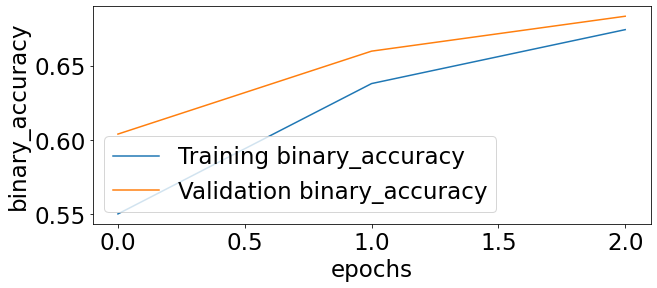

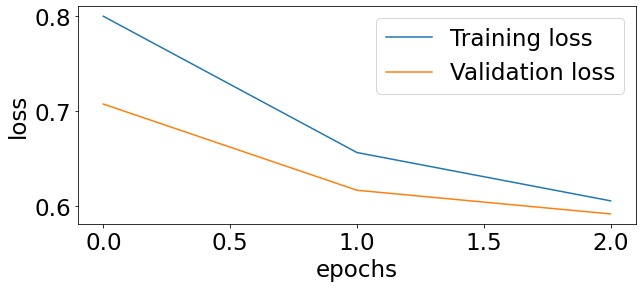

In [30]:
# Train the model
trained_transformer_model, training_history, exec_time = train_transformer(compiled_transformer_model, 
                                                                           preprocess.tf_train_dataset,
                                                                           preprocess.tf_validation_dataset,
                                                                           my_callbacks)

In [31]:
# ######################
# # Launch TensorBoard
# ######################
# # Change the pwd, so that TensorBoard may locate the logs
# %cd $experiment_dir

# #Start TensorBoard through the command line or within a notebook experience. 
# # The two interfaces are generally the same. In notebooks, use the %tensorboard line magic. 
# # On the command line, run the same command without "%"
# %tensorboard --logdir logs/fit
# # Takes some time to launch

# # For Comparing different executions of your model see 
# # https://github.com/tensorflow/tensorboard/blob/master/README.md#runs-comparing-different-executions-of-your-model

In [32]:
# # Kill tensorboard
# !kill 2022

## Infer

In [33]:
def infer(model, test_dataset, tokenized_dataset, batch_size, threshold, anomalies):
    """
    - Calculate scores on the metrics defined during model.compile()
    - Get multilabel predictions y_pred_proba, i.e. 'num_classes' 
      probabilities for each data entry
    - Convert probabilities y_pred_proba into y_pred, i.e. binary (0,1) 
      multilabels
    - Construct the classification report

    Inputs
    -------
    - test_dataset (tf.data.Dataset): best is to use the attribute of a 
      'DataPrepMultilabelBERT' class instance
    - tokenized_dataset (HuggingFace dataset). Best is to use the attribute 
      of a 'DataPrepMultilabelBERT' class instance
    - batch_size (int): best is to use the attribute of a 
      'DataPrepMultilabelBERT' class instance
    - threshold for the probability --> binary conversion
    - anomalies (list of str): Used to label the classification report.
      Best use the .anomalies attribute of a 'DataPrepMultilabelBERT' class 
      object

    Return
    -------
    - evaluation_scores: output of tensforflow method 'model.evaluate()'
    - y_pred_proba: output of tensforflow method 'model.predict()'. 
      Multilabel probabilities.
    - y_pred: binary (0,1) multilabels
    - y_test: binary (0,1) multilabels
    - clf_rep: classification report in dictionary format

    Notes
    ------
    Ioannis initially created this function as a 'ClassifTransformerModelML'
    class method. Because the latter is a custom model, the method was
    'untraced' and therefore was not part of *reloaded* models. 
    This is why the infer() function is now defined outside the class. 
    """
    print("Evaluation scores on the test set (usually: loss and accuracy):")
    evaluation_scores = model.evaluate(test_dataset)
    print(evaluation_scores, '\n')
    
    print("Predicting multilabel probabilities y_pred_proba...")
    y_pred_proba = model.predict(test_dataset, #tokenized_dataset["test"]['input_ids'], 
                                batch_size = batch_size, 
                                verbose = 1)
    print("Shape of y_pred_proba:", y_pred_proba.shape, '\n')
    print("Example of entry in y_pred_proba:", y_pred_proba[0], '\n')

    print("Converting probabilities into binary (0,1) multilabel 'y_pred' using threshold =", threshold)
    y_pred = y_prob_to_y_pred_ML(y_pred_proba, threshold = threshold)
    print("Example of entry in y_pred:", y_pred[0])

    print("\n Getting y_test from tokenized test dataset in HuggingFace dataset format.")
    y_test = tokenized_dataset["test"]['labels']

    # Classification report
    clf_rep = classification_report(y_test, y_pred, output_dict = True)
    print(f"\n\n Classification Report: \n {classification_report(y_test, y_pred, target_names = anomalies)}\n")

    return evaluation_scores, y_pred_proba, y_pred, y_test, clf_rep


In [34]:
evaluation_scores, y_pred_proba, y_pred, y_test, clf_rep = infer(trained_transformer_model,
                                                                 preprocess.tf_test_dataset,
                                                                preprocess.tokenized_dataset,
                                                                preprocess.batch_size,
                                                                threshold = 0.5, 
                                                                anomalies = preprocess.anomalies)

Evaluation scores on the test set (usually: loss and accuracy):
125/125 [==============================] - 2s 16ms/step - loss: 0.5879 - binary_accuracy: 0.6859
[0.5878502726554871, 0.6859463453292847] 

Predicting multilabel probabilities y_pred_proba...
The call() method of a ClassifTransformerModelML class object has been called.

125/125 [==============================] - 2s 14ms/step
Shape of y_pred_proba: (4000, 14) 

Example of entry in y_pred_proba: [0.6379578  0.04575584 0.46788546 0.49645722 0.5443143  0.16165432
 0.19716586 0.19063763 0.54698896 0.51690257 0.51779217 0.1885321
 0.16357192 0.18856785] 

Converting probabilities into binary (0,1) multilabel 'y_pred' using threshold = 0.5
Example of entry in y_pred: [1 0 0 0 1 0 0 0 1 1 1 0 0 0]

 Getting y_test from tokenized test dataset in HuggingFace dataset format.


 Classification Report: 
                                               precision    recall  f1-score   support

Anomaly_Deviation / Discrepancy - Procedural 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [35]:
# evaluation_scores, y_pred_proba, y_pred, y_test, clf_rep = trained_transformer_model.infer(preprocess.tf_test_dataset,
#                                                                                    preprocess.tokenized_dataset,
#                                                                                   preprocess.batch_size,
#                                                                                   threshold = 0.5, 
#                                                                                   anomalies = preprocess.anomalies)

In [36]:
# model_eval = trained_transformer_model.evaluate(tf_test_dataset)
# # evaluate() does not call the call() method of our model; it is not a method 
# # of the model

In [37]:
# y_pred_proba = trained_transformer_model.predict(tf_test_dataset, #tokenized_dataset["test"]['input_ids'], 
#                             batch_size = preprocess.batch_size, 
#                             verbose = 1)
# y_pred_proba.shape 

In [38]:
# print(len(y_pred_proba))
# y_pred_proba[0] # probabilities

In [39]:
# y_pred = y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5) # call the function
# y_pred[0]

### Classification report

In [40]:
# Classification report in form of a pd.DataFrame
clf_rep_df = convert_clf_rep_to_df_multilabel_BERT(clf_rep, 
                                                   preprocess.anomalies)

DataFrame length: 56


In [41]:
# y_test = preprocess.tokenized_dataset["test"]['labels']
# print(classification_report(y_test, y_pred, target_names = preprocess.anomalies))

## Save

In [42]:
def save_transformer(model, experiment_dir):
  """
  Saves the model using model.save(), an alias of tf.keras.models.save_model()
  method

  Inputs
  ------
  - experiment_dir (str): directory of the experiment. The data will be saved here.

  Return
  ------
  - None; this function saves data externally

  Notes on execution
  -------------------
  - The experiment_dir is created automatically, if not already existing.
  - If you are about to overwrite a saved model, you will get a prompt.
    You could change this setting to overwritting by default, e.g. if you let
    a model train for hours and want to make sure it is saved (in case you are 
    not there to type the 'y' inside the promt). 
  - It is normal to see 7x the msg.
    'The call() method of a ClassifTransformerModelML class object 
    has been called.'; It remains unclear why the object is called 7x during save.
  - The file takes some time to appear in the experiment_dir 
    (at least if it's a Google Drive folder).
  - Executing for a model containing BERT, will probably print something like 
    'WARNING:absl:Found untraced functions such as embeddings_layer_call_fn, etc.'
    Apparently there are ~80 functions that 'will not be *directly* callable after loading.'
    Ioannis thinks that this is not a problem, since the loaded model can be 
    successfully compiled and trained.

  Notes on available formats for saving models
  ---------------------------------------------
  There are two formats you can use to save an entire model to disk: 
  - the TensorFlow SavedModel format
  - the older Keras H5 format. 
  
  **The recommended format is TensorFlow SavedModel.**

  SavedModel is the more comprehensive save format that saves 
  - the model architecture, 
  - weights, 
  - the traced Tensorflow subgraphs of the call functions. 
  
  This enables Keras to restore both built-in layers as well as custom objects.
  When saving in TensorFlow SavedModel format, a folder is created containing 
  the files/folders:
  - assets  
  - keras_metadata.pb  
  - saved_model.pb  
  - variables

  On the other hand, HDF5 is a single file containing 
  - the model's architecture, 
  - weights values (which were learned during training), 
  - compile() information (if compile() was called)
  - the optimizer and its state, if any (this enables you to restart training 
  where you left)
  See https://www.tensorflow.org/guide/keras/save_and_serialize
  
  HDF5 is a light-weight alternative to TensorFlow SavedModel with imitations
  (see https://www.tensorflow.org/guide/keras/save_and_serialize#limitations)

  /!\ In any case: DO NOT USE .pkl (pickle) file format for DEEP LEARNING models !

  Notes on implementation
  ------
  Ioannis initially created this function as a 'ClassifTransformerModelML'
  class method. Because the latter is a custom model, the method was
  'untraced' and therefore was not part of *reloaded* models. 
  This is why the infer() function is now defined outside the class. 
  """
  # Define options for saving to SavedModel
  # We save as much info as possible
  tf_save_model_opts = tf.saved_model.SaveOptions(namespace_whitelist=None,
                                                  save_debug_info = True, # default is False
                                                  function_aliases=None,
                                                  experimental_io_device=None,
                                                  experimental_variable_policy=None,
                                                  experimental_custom_gradients=True)

  # model.save() is an alias for tf.keras.models.save_model()
  # Difference between tf.saved_model.save and tf.keras.model.save: none essentially
  model.save(
      filepath = experiment_dir,
      overwrite=False, #False: ask the user with a manual prompt
      include_optimizer=True, # save optimizer's state together
      save_format=None, # Either 'tf' for Tensorflow SavedModel or 'h5' HDF5, defaults to 'tf' in TF 2.X, and 'h5' in TF 1.X.
      signatures=None, # Signatures to save with the SavedModel. Applicable to the 'tf' format only
      options = tf_save_model_opts,
      save_traces=True # when save_traces=False, all custom objects must have defined get_config/from_config methods. When loading, the custom objects must be passed to the custom_objects argument. save_traces=False reduces the disk space used by the SavedModel and saving time.
  )
  print("Model successfully saved in:\n", experiment_dir)

### the model

In [43]:
# trained_transformer_model.save_transformer(experiment_dir)
save_transformer(trained_transformer_model, experiment_dir)

[WARNING] /content/drive/MyDrive/data/saved models/Yannis/BERT/saving_tests/test2 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
The call() method of a ClassifTransformerModelML class object has been called.

The call() method of a ClassifTransformerModelML class object has been called.

The call() method of a ClassifTransformerModelML class object has been called.

The call() method of a ClassifTransformerModelML class object has been called.

The call() method of a ClassifTransformerModelML class object has been called.

The call() method of a ClassifTransformerModelML class object has been called.

The call() method of a ClassifTransformerModelML class object has been called.



Model successfully saved in:
 /content/drive/MyDrive/data/saved models/Yannis/BERT/saving_tests/test2


### the classification results y_pred_proba, y_pred, classification report and y_test

In [44]:
save_ML_outputs(dir_name, experiment_name, 
                y_pred_proba = y_pred_proba, 
                y_pred = y_pred, 
                y_test = y_test, 
                clf_rep = clf_rep)

Saving y_pred_proba ...
Saving y_pred ...
Saving y_test ...
Saving clf_rep ...


Multilabel results were successfully saved in 
 /content/drive/MyDrive/data/saved models/Yannis/BERT/saving_tests/


## Load the model

In [45]:
# Delete the model, to see if it is really freshly loaded
del trained_transformer_model

In [46]:
# LOAD and re-train 
from tensorflow.keras.models import load_model
# use the custom_object parameter while loading the model if you've custom layer-like stuff.
# alternatively, the @tf.keras.utils.register_keras_serializable() decorator can be used
# in the CustomLayer or CumstomModel class definitions
# see https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
loaded_model = keras.models.load_model(filepath = experiment_dir, 
                                      custom_objects={"ClassifTransformerModelML": ClassifTransformerModelML, 
                                                      "ConcatSlice": ConcatSlice},
                                      compile=True # whether to compile the model after loading. 
                                      # Works only if the original model was compiled, and saved with the optimizer
                                      )

Will get the output(s) of layer(s): last_hidden_state
Setting used (CLS or flatten?): CLS 



------- Execution started... -------
Epoch 1/3
400/400 [==============================] - 14s 29ms/step - loss: 0.5404 - binary_accuracy: 0.7392 - val_loss: 0.4941 - val_binary_accuracy: 0.7923
Epoch 2/3
400/400 [==============================] - 10s 26ms/step - loss: 0.4819 - binary_accuracy: 0.8007 - val_loss: 0.4585 - val_binary_accuracy: 0.8239
Epoch 3/3
400/400 [==============================] - 12s 29ms/step - loss: 0.4604 - binary_accuracy: 0.8204 - val_loss: 0.4485 - val_binary_accuracy: 0.8308
------- Training finished! -------
--- It took 1.1 minutes --- 




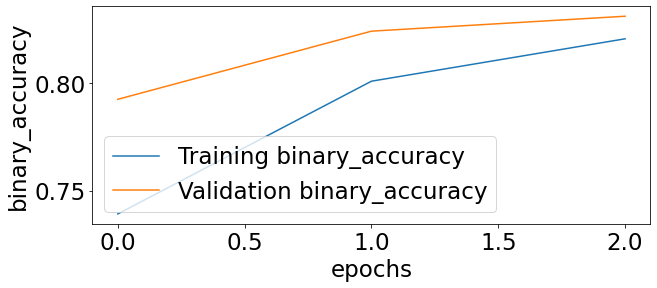

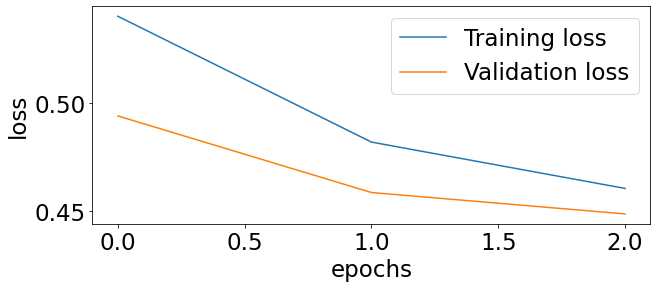

In [47]:
# Fit loaded model
loaded_model_retrained, training_history, exec_time = train_transformer(loaded_model,
                                                                        preprocess.tf_train_dataset,
                                                                        preprocess.tf_validation_dataset,
                                                                        my_callbacks)

In [48]:
evaluation_scores, y_pred_proba, y_pred, y_test, clf_rep = infer(loaded_model_retrained,
                                                                 preprocess.tf_test_dataset,
                                                                preprocess.tokenized_dataset,
                                                                preprocess.batch_size,
                                                                threshold = 0.5, 
                                                                anomalies = preprocess.anomalies)

Evaluation scores on the test set (usually: loss and accuracy):
125/125 [==============================] - 2s 19ms/step - loss: 0.4478 - binary_accuracy: 0.8314
[0.4478347897529602, 0.831356942653656] 

Predicting multilabel probabilities y_pred_proba...
125/125 [==============================] - 3s 18ms/step
Shape of y_pred_proba: (4000, 14) 

Example of entry in y_pred_proba: [0.69440603 0.07017233 0.39954808 0.31084004 0.49030107 0.14008713
 0.09208302 0.11456106 0.37718356 0.2268445  0.26013932 0.08537618
 0.07340606 0.15224087] 

Converting probabilities into binary (0,1) multilabel 'y_pred' using threshold = 0.5
Example of entry in y_pred: [1 0 0 0 0 0 0 0 0 0 0 0 0 0]

 Getting y_test from tokenized test dataset in HuggingFace dataset format.


 Classification Report: 
                                               precision    recall  f1-score   support

Anomaly_Deviation / Discrepancy - Procedural       0.59      0.97      0.74      2377
                  Anomaly_Aircraft Equi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [49]:
# model_eval = loaded_model_retrained.evaluate(tf_test_dataset)

In [50]:
# y_pred_proba_from_reloaded = loaded_model_retrained.predict(tf_test_dataset, 
#                             batch_size = preprocess.batch_size, 
#                             verbose = 1)

In [51]:
# Check if the loaded model can be saved
save_transformer(loaded_model_retrained, experiment_dir)

[WARNING] /content/drive/MyDrive/data/saved models/Yannis/BERT/saving_tests/test2 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


Model successfully saved in:
 /content/drive/MyDrive/data/saved models/Yannis/BERT/saving_tests/test2
